In [ ]:
!pip install kagglehub lime

In [29]:
# import
import kagglehub
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from lime import lime_image
from skimage.segmentation import mark_boundaries

In [30]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 53944), started 0:05:20 ago. (Use '!kill 53944' to kill it.)

In [ ]:
# Constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
subset_size = 2000
batch_size = 32
epochs = 100
learning_rate = 1e-4
seed=42
num_workers=2

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)

In [33]:
# Download dataset
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Dataset:", path)

Dataset: /home/lois/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [ ]:
# Dataset loading
image_paths_dict = {}
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.jpg'):
            image_id = os.path.splitext(file)[0]
            image_paths_dict[image_id] = os.path.join(root, file)

metadata_path = os.path.join(path, 'HAM10000_metadata.csv')

df = pd.read_csv(metadata_path)
df['path'] = df['image_id'].map(image_paths_dict.get)
df = df.dropna(subset=['path'])

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['cell_type'] = df['dx'].map(lesion_type_dict.get)

le = LabelEncoder()
df['label'] = le.fit_transform(df['cell_type'])
num_classes = len(le.classes_)


In [ ]:
# Creation subset / dataset
if subset_size < len(df):
    df_subset = df.sample(n=subset_size, random_state=seed).reset_index(drop=True)
else:
    df_subset = df

train_df, test_df = train_test_split(df_subset, test_size=0.2, stratify=df_subset['label'], random_state=seed)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(int(self.df.iloc[idx]['label']), dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

train_dataset = SkinDataset(train_df, transform=data_transforms['train'])
test_dataset = SkinDataset(test_df, transform=data_transforms['val'])
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

In [ ]:
# Transfer Learning
model = models.resnet18(pretrained=True)

for param in model.parameters(): # freeze all layers
    param.requires_grad = False

# Replace last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

class_counts = df_subset['label'].value_counts().sort_index().values
total_samples = sum(class_counts)
class_weights = torch.tensor([total_samples / (len(class_counts) * c) for c in class_counts], dtype=torch.float)
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(class_weights=class_weights)
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)


/home/lois/Documents/mlbio/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lois/Documents/mlbio/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training
writer = SummaryWriter('runs/skin_cancer_experiment')
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        writer.add_scalar('Training/Batch_Loss', loss.item(), epoch * len(train_loader) + i)
    
    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(train_loader) 
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_acc = 100 * correct_val / total_val
    val_loss /= len(test_loader)
    
    writer.add_scalars('Loss', {'Train': epoch_loss, 'Val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': epoch_acc, 'Val': val_acc}, epoch)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
writer.close()

In [37]:
# Save model
torch.save(model.state_dict(), 'skin_lesion_resnet18.pth')

# Run lime

In [ ]:
model_path = "models/skin_lesion_resnet18.pth"

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

weights_dict = torch.load(model_path, map) if os.path.exists(model_path) else model 

model.load_state_dict(weights_dict)

Poids chargés avec succès dans le modèle !


/home/lois/Documents/mlbio/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lois/Documents/mlbio/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Démarrage de LIME ---
Explication pour l'image 156. Classe réelle : Melanocytic nevi


100%|██████████| 2000/2000 [00:35<00:00, 56.33it/s]


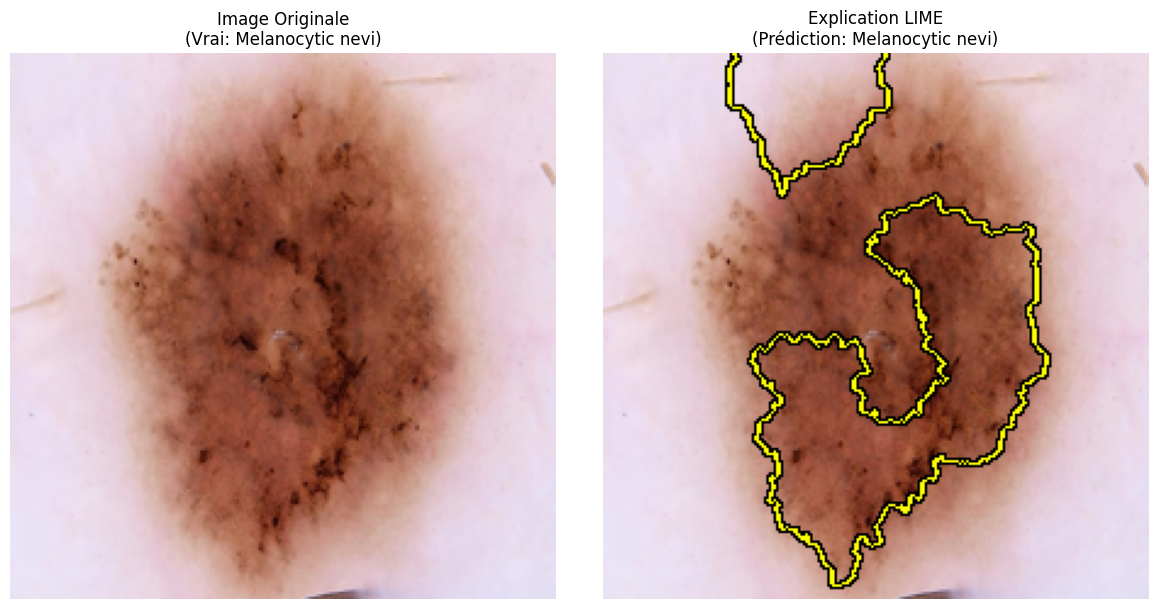

In [ ]:
def batch_predict(images):
    model.eval()
    batch = torch.stack([data_transforms['val'](Image.fromarray(i)) for i in images], dim=0)
    batch = batch.to(device)
    with torch.no_grad():
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

explainer = lime_image.LimeImageExplainer()

idx = np.random.randint(0, len(test_dataset))
img_tensor, label_idx = test_dataset[idx]
img_path = test_df.iloc[idx]['path']
img_numpy = np.array(Image.open(img_path).convert('RGB').resize((224, 224)))

print(f"Image{idx}. Reel class : {le.classes_[label_idx]}")

explanation = explainer.explain_instance(
    img_numpy, 
    batch_predict, 
    top_labels=5, 
    hide_color=0, 
    num_samples=2000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False 
)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_numpy)
plt.title(f"Original image\n(True: {le.classes_[label_idx]})")
plt.axis('off')

plt.subplot(1, 2, 2)

img_to_show = temp.copy()
if img_to_show.max() > 1:
    img_to_show = img_to_show / 255.0
    
plt.imshow(mark_boundaries(img_to_show, mask, color=(1, 1, 0), outline_color=(0, 0, 0)))
plt.title(f"Explanation LIME\n(Prediction: {le.classes_[explanation.top_labels[0]]})")
plt.axis('off')

plt.tight_layout()
plt.show()